Several variables show missing entries (see @fig-missing), particularly in episodes' task complexity. The task complexity in any episode is computed by taking an average of complexity levels of tasks completed by a student. Therefore, if a student has not completed any tasks in an episode then the task complexity for that episode is not defined. 

In [163]:
import pandas as pd

# load data
df = pd.read_csv('../Eduflex.xlsx - Pankajile.csv')

df.set_index('Student_ID',inplace=True)

# columns containing knowledge-related data
knowledge_cols = ['pre_knowl','post_knowl','knowledge gain']

# columns containing self-reported data
self_report_cols = ['T5_learning difficulty',
                     'T2_Post_effectiveness',
                     'T4_Post_needforhelp',
                     'T7_shared_control_student',
                     'T8_shared_teacher',
                     'T11__cogn_load',
                     'T13_own_effort',
                     'T14_TAM_easy']

# columns containing episodes data
episodes_cols =[item for item in df.columns.to_list() if item not in knowledge_cols + self_report_cols + ['Gender']]

# knowledge data
df_knowledge = df[knowledge_cols]

# self-reported data
df_self_report = df[self_report_cols]

# episodes data
df_episodes = df[episodes_cols]


/var/folders/yz/d_7lkc5d3136jv69fndfsmfm0000gn/T/ipykernel_4143/3927300224.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=missing_counts.index,


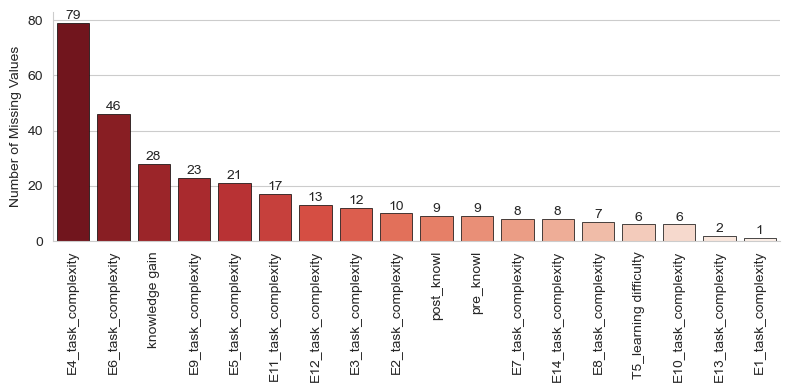

In [165]:
#| label: fig-missing
#| fig-cap: "Missing Values"
#| fig-align: center
#| warning: false

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate missing counts
missing_counts = df.isnull().sum().sort_values(ascending=False)
missing_counts = missing_counts[missing_counts > 0]  # Only show variables with missing data

# Create plot
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=missing_counts.index, 
                 y=missing_counts.values,
                 palette="Reds_r",  # Red gradient (dark = more missing)
                 edgecolor='black',
                 linewidth=0.5)

# Add value labels
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

# Style adjustments
plt.title("", pad=15)
plt.xlabel("")
plt.ylabel("Number of Missing Values")
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()
plt.show()

# Handling missing values
<hr/>
We will handle the missing values in the following manner.

* **Delete** all records where **knowledge related information** is missing (i.e., records having missing values for knowledge gain, pre knowledge or post knowledge)
* **Remove records** with missing values in **T5_learning_difficulty**.
* **Remove episode E4** data. This episode consisting of two tasks and a significant number of students did not completed those tasks.
* **Impute** missing values for task complexity in rest of the episodes. This decision will allow us to generate new features (we will discuss them in the next section.
                                                                         

In [157]:
# Delete all records where knowledge related information is missing
df_knowledge_clean = df_knowledge.dropna(axis=0, how='any')

# Deleting records with missing value in T5_learning_difficulty column
df_self_report_clean = df_self_report.dropna(axis=0,how='any')

# Removing E4 episode
e4_non_cols = [item for item in df_episodes.columns if 'E4' not in item]
df_episodes_non_e4 = df_episodes[e4_non_cols]

# Impute complexity with a very small number
df_episodes_clean = df_episodes_non_e4.fillna(0.00000001)

# Final dataframe
clean_df = df_knowledge_clean.join(df_self_report_clean, how='inner').join(df_episodes_clean, how='inner')

/var/folders/yz/d_7lkc5d3136jv69fndfsmfm0000gn/T/ipykernel_4143/4025213434.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[df.shape[0], clean_df.shape[0]],


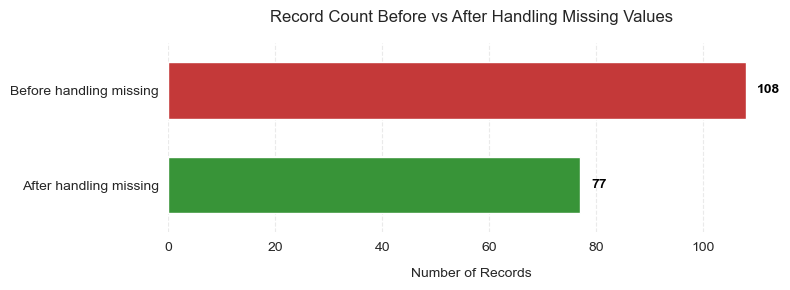

In [167]:
#| label: fig-stats
#| fig-cap: "Before and after handling missing values"
#| fig-align: center
#| warning: false


# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(8, 3))

# Create plot
ax = sns.barplot(x=[df.shape[0], clean_df.shape[0]], 
                 y=['Before handling missing', 'After handling missing'],
                 palette=["#d62728", "#2ca02c"],  # Red/Green color scheme
                 saturation=0.8,
                 width=0.6)

# Add value labels
for i, v in enumerate([df.shape[0], clean_df.shape[0]]):
    ax.text(v + max([df.shape[0], clean_df.shape[0]])*0.02, i, 
            f"{v:,}", 
            color='black', 
            va='center',
            fontweight='bold')

# Styling
plt.title("Record Count Before vs After Handling Missing Values", pad=15)
plt.xlabel("Number of Records", labelpad=10)
plt.ylabel("")
sns.despine(left=True, bottom=True)
ax.grid(axis='x', linestyle='--', alpha=0.4)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

```
E1, E2 , E6	Prior knowledge
E3, E4, E7, E9, E10, E12, E13	Getting familiar with new topic
E5, E8, E11, E14	Practicing
```

# Restructuring the data
<hr/>
We will now restructure the data for simplifying our analysis later. In this restructure, we will transform the Episode interaction data from `Wide` format to `Long` format. That is converting the data from its current form (each student's record in a single row for all episodes) to a new form (one row will contain only interaction to a single episode). 

The new data will look like the below dataframe.

In [222]:
import pandas as pd
import numpy as np

# First, let's identify all episode prefixes (E1, E2, etc.)
episode_cols = [col for col in df.columns if col.startswith('E') and not '_' in col]
episode_prefixes = [col for col in episode_cols if col.replace('E','').isdigit()]

# Create a list to store all transformed episode data
episode_data = []

for prefix in episode_prefixes:
    # Get all columns for this episode
    episode_cols = [col for col in df.columns if col.startswith(prefix + '_') or col == prefix]

    
    # Create a temporary DataFrame for this episode
    episode_df = df[episode_cols].copy()

    # Rename columns by removing the episode prefix
    new_cols = {}
    for col in episode_df.columns:
        if col == prefix:
            new_cols[col] = 'episode_id'
        else:
            new_cols[col] = col[len(prefix)+1:]  # Remove prefix and underscore
    
    episode_df = episode_df.rename(columns=new_cols)

    episode_df['episode_id'] = prefix[1:]
    
    # Add student ID if available
    episode_df['Student_ID'] = df.index
    
    
    episode_data.append(episode_df)

# Combine all episodes into one DataFrame
long_df = pd.concat(episode_data, ignore_index=True)

# Clean up column names (handle inconsistent naming)
long_df.columns = long_df.columns.str.strip('_').str.lower()

# Standardize column names (fix E13/E14 inconsistencies)
column_mapping = {
    'total hints': 'total_hints',
    'total materials': 'total_materials',
    'total_activity': 'total_activity_count',
    '__addmat_used': 'addmat_used'
}
long_df = long_df.rename(columns=column_mapping)

# Reorder columns if needed
base_cols = ['student_id', 'episode_id'] if 'student_id' in long_df.columns else ['episode_id']
metric_cols = [col for col in long_df.columns if col not in base_cols]
long_df = long_df[base_cols + sorted(metric_cols)]

# Converting task_complexity data type
long_df.task_complexity = pd.to_numeric(long_df.task_complexity, errors='coerce')
long_df.fillna({'task_complexity':0.000001}, inplace=True)


long_df.head()

,student_id,episode_id,addmat_used,hints_used,task_complexity,tasks_completed,total_activity_count,total_hints,total_materials,total_tasks
0,keila1,1,0.0,0.00,1.43,87.5,42,3.0,2.0,8
1,keila2,1,0.0,66.67,1.43,87.5,75,3.0,2.0,8
2,keila3,1,0.0,0.00,1.33,37.5,28,3.0,2.0,8
3,keila4,1,0.0,66.67,1.50,50.0,73,3.0,2.0,8
4,keila5,1,0.0,33.33,1.50,50.0,41,3.0,2.0,8


#### Column explanation

| Column Name             | Description                                                                 | Example       |
|-------------------------|-----------------------------------------------------------------------------|---------------|
| **episode_id**          | Unique identifier for the learning episode (e.g., 1, 2)                   | `"10"`       |
| **student_id**          | Unique identifier for the student              | `"keila1"`       |
| **addmat_used**         | Percentage of additional/supplementary materials accessed by the student         | `50`           |
| **hints_used**          | Percentage of hints requested by the student during tasks                       | `33.3`           |
| **task_complexity**     | Numeric measure of task difficulty of tasks completed by the student (higher = more complex)                  | `0.75`        |
| **tasks_completed**     | Percentage of tasks successfully finished by the student                        | `50`           |
| **total_activity_count**| Total interactions/actions taken by the student in the episode              | `17`          |
| **total_hints**         | Maximum hints available in the episode                                      | `5`           |
| **total_materials**     | Total supplementary materials available in the episode                      | `4`           |
| **total_tasks**         | Total tasks available in the episode                                        | `8`           |

# New feature generation
<hr/>
Now, we will generate some new features from the existing ones. The goal is to take complexity into account to generate measures for hints used and task completed.

**Logic**

* `adjusted_hints_used = hints_used / task_complexity` : If a student has used a same percentage of hints in two episodes having tasks with different complexity then hints used for difficult tasks will be treated lower than hints used for simple tasks.

* `adjusted_task_completion = tasks_completed * task_complexity`: If a student has completed a same percentage of tasks in two episodes having tasks with different complexity then completion for difficult tasks will be treated higher than task completion of simple tasks.

In [261]:
# New feature generation
long_df['adjusted_hints_used'] = (long_df['hints_used'] * long_df['total_hints'] * .001) / long_df['task_complexity']
long_df['adjusted_tasks_completed'] = (long_df['tasks_completed'] * long_df['total_hints'] * .001) * long_df['task_complexity']
long_df['adjusted_activities'] = long_df['total_activity_count'] / long_df['total_tasks']
# Save the DataFrame
long_df.to_csv('restructure_vara_data.csv',index=False)

0       0.000000
1       0.139867
2       0.000000
3       0.133340
4       0.066660
          ...   
1507    0.000000
1508    0.000000
1509    0.000000
1510    0.000000
1511    0.000000
Name: adjusted_hints_used, Length: 1512, dtype: float64

# Aggregating behavioral measures for all episodes
We will now aggregate episodes data for each students. We will obtain the following measures for three attributes: `adjusted_hints_used`, `adjusted_tasks_completed`, `adjusted_activities`

* Mean
* Median
* Min
* Max
* Standard deviation
* Total
* Quartile-1
* Quartile-3

In [273]:
# Group by student_id and calculate statistics for selected columns
student_stats = long_df.groupby('student_id').agg({
    'adjusted_hints_used': [
        ('mean', 'mean'),
        ('total', 'sum'),
        ('std', 'std'),
        ('median', 'median'),
        ('q1', lambda x: x.quantile(0.25)),
        ('q3', lambda x: x.quantile(0.75))
    ],
    'adjusted_tasks_completed': [
        ('mean', 'mean'),
        ('total', 'sum'),
        ('std', 'std'),
        ('median', 'median'),
        ('q1', lambda x: x.quantile(0.25)),
        ('q3', lambda x: x.quantile(0.75))
    ],
    'adjusted_activities': [
        ('mean', 'mean'),
        ('total', 'sum'),
        ('std', 'std'),
        ('median', 'median'),
        ('q1', lambda x: x.quantile(0.25)),
        ('q3', lambda x: x.quantile(0.75))
    ]
})

# Flatten multi-level column names
student_stats.columns = ['_'.join(col).strip() for col in student_stats.columns.values]

# Reset index to keep student_id as a column
student_stats = student_stats.reset_index()

# Saving cleaned data
student_stats.to_csv('agg_behavior_metrics.csv',index=False)

df_self_report_clean['student_id']= df_self_report_clean.index
df_self_report_clean.to_csv('self_report_clean.csv',index=False)

df_knowledge_clean['student_id']= df_knowledge_clean.index
df_knowledge_clean.to_csv('knowledge_clean.csv',index=False)

student_stats.head()

,student_id,adjusted_hints_used_mean,adjusted_hints_used_total,adjusted_hints_used_std,adjusted_hints_used_median,adjusted_hints_used_q1,adjusted_hints_used_q3,adjusted_tasks_completed_mean,adjusted_tasks_completed_total,adjusted_tasks_completed_std,adjusted_tasks_completed_median,adjusted_tasks_completed_q1,adjusted_tasks_completed_q3,adjusted_activities_mean,adjusted_activities_total,adjusted_activities_std,adjusted_activities_median,adjusted_activities_q1,adjusted_activities_q3
0,keila1,0.024041,0.288497,0.060975,0.0,0.0,0.000000,0.113145,1.357741,0.180667,0.000000,0.0,0.135000,9.749196,136.488745,7.902623,10.943182,1.312500,14.835714
1,keila11,0.008332,0.099990,0.028865,0.0,0.0,0.000000,0.209937,2.519240,0.300722,0.095455,0.0,0.318844,11.939590,167.154257,7.239382,12.055556,7.718750,16.031818
2,keila12,0.008332,0.099990,0.028865,0.0,0.0,0.000000,0.087322,1.047865,0.128274,0.010795,0.0,0.153881,5.480523,76.727327,5.265849,4.341667,1.671875,7.642857
3,keila13,0.025626,0.307517,0.046397,0.0,0.0,0.024997,0.122172,1.466061,0.167201,0.045455,0.0,0.187219,13.117858,183.650018,9.252567,14.085227,4.500000,19.980952
4,keila14,0.028321,0.339857,0.052167,0.0,0.0,0.024997,0.284265,3.411185,0.476059,0.095455,0.0,0.365250,17.456810,244.395346,8.207705,16.375000,11.017857,21.779167
